In [324]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from tqdm import tqdm
import os

data_dir = 'data/'


ratings_train = torch.tensor(np.load(os.path.join(data_dir, 'ratings_train.npy')), dtype=torch.float32)
ratings_test = torch.tensor(np.load(os.path.join(data_dir, 'ratings_test.npy')), dtype=torch.float32)
names_genres = np.load(os.path.join(data_dir, 'namesngenre.npy'))

In [325]:
print(ratings_train.shape)
print(f"% of missing values for the training matrix : {np.isnan(ratings_train).sum()/(ratings_train.shape[0]*ratings_train.shape[1])}")
print(ratings_test.shape)
print(f"% of missing values for the testing matrix : {np.isnan(ratings_test).sum()/(ratings_test.shape[0]*ratings_test.shape[1])}")
print(names_genres)

torch.Size([610, 4980])
% of missing values for the training matrix : 0.9895983934402466
torch.Size([610, 4980])
% of missing values for the testing matrix : 0.9895983934402466
[['Toy Story (1995)' 'Adventure|Animation|Children|Comedy|Fantasy']
 ['Jumanji (1995)' 'Adventure|Children|Fantasy']
 ['Grumpier Old Men (1995)' 'Comedy|Romance']
 ...
 ['Elsa & Fred (2005)' 'Comedy|Drama|Romance']
 ['Tomb Raider (2018)' 'Action|Adventure|Fantasy']
 ['Fred Armisen: Standup for Drummers (2018)' 'Comedy']]


In [326]:
class AutoRecEncoder(nn.Module) :
    def __init__(self, d, k, dropout) :
        print(f"AutoRec Encoder : d={d}, k={k}, dropout={dropout}")
        super().__init__()
        self.encoder=nn.Sequential(
        nn.Linear(d,k),
        nn.Sigmoid(), # Can be changed
        # nn.ReLU(),
        nn.Dropout(dropout))
        self.decoder=nn.Linear(k,d)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [327]:
def get_mask(ratings):
    mask = ~torch.isnan(ratings)  # True là où il y a une valeur, False là où il y a un NaN
    ratings = torch.nan_to_num(ratings, nan=0.0)  # Remplace temporairement les NaN par 0
    return ratings, mask.float()

def compute_rmse(pred, true, mask):
    # On ne considère que les valeurs observées (où mask = 1)
    loss = torch.sum(((pred - true) ** 2) * mask) / torch.sum(mask)
    return torch.sqrt(loss)

_, mask = get_mask(ratings_train)
print(mask)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [328]:
print(ratings_train.shape)

torch.Size([610, 4980])


In [329]:
num_movies = ratings_train.shape[1] # For user-based
num_users = ratings_train.shape[0] # For item-based

model = AutoRecEncoder(num_users,500,dropout=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
ratings_train, train_mask = get_mask(ratings_train.T)

epochs = 200
verbose = False
loss_values = []
batch_size = 32
device = "cuda"
train_dataset = TensorDataset(ratings_train, train_mask)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
model = model.to(device)

pbar = tqdm(range(epochs))
for epoch in pbar :
    model.train()
    epoch_loss = 0
    for batch_ratings, batch_mask in train_loader :
        batch_ratings = batch_ratings.to(device)
        batch_mask = batch_mask.to(device)
        optimizer.zero_grad()
        output_matrix = model(batch_ratings)
        loss = compute_rmse(output_matrix, batch_ratings, batch_mask)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss /= len(train_loader)
    pbar.set_description(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")
    loss_values.append(epoch_loss)
    if verbose :
        if (epoch +1) %10 == 0 : 
            print(f"loss at epoch {epoch + 1} : {epoch_loss}")

AutoRec Encoder : d=610, k=500, dropout=False


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200, Loss: 0.1710: 100%|██████████| 200/200 [01:23<00:00,  2.40it/s]


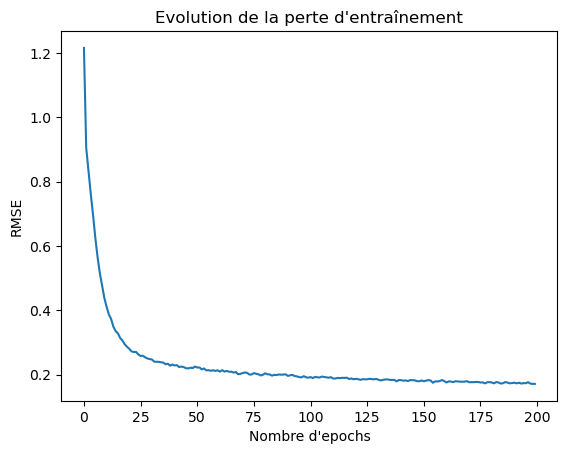

In [330]:
plt.plot(list(np.arange(len(loss_values))),loss_values)
plt.title("Evolution de la perte d'entraînement")
plt.xlabel("Nombre d'epochs")
plt.ylabel("RMSE")
plt.show()

In [331]:
# ratings_test = torch.Tensor(np.load("ratings_test.npy"))
ratings_test, mask_test = get_mask(ratings_test.T)
model.eval()
with torch.no_grad():
    predictions_test = model(ratings_test.to(device))
test_loss = compute_rmse(predictions_test, ratings_test.to(device), mask_test.to(device))
print(f"Test RMSE: {test_loss.item()}")
predictions_test_rounded = (predictions_test.clone() *2).round()/2
test_loss = compute_rmse(predictions_test_rounded, ratings_test.to(device), mask_test.to(device))
print(f"Test RMSE avec arrondis: {test_loss.item()}")

Test RMSE: 0.6927416920661926
Test RMSE avec arrondis: 0.7049552202224731


In [332]:
# Print the predictions for a user that we can compare with the true values based on the mask
user = 0
# So we get the [user]th column of the predictions and the true ratings
predictions = predictions_test_rounded.T[user]
true_ratings = ratings_test.T[user]
mask = mask_test.T[user]
print("Predictions : ", predictions[mask == 1])
print("True ratings : ", true_ratings[mask == 1])
print("Names of the movies : ", names_genres[mask == 1])

Predictions :  tensor([3.5000, 4.0000, 4.0000, 4.5000, 4.5000, 3.5000, 3.5000, 4.5000, 4.0000,
        4.0000, 4.5000, 3.5000, 4.0000, 3.0000, 5.0000, 3.5000, 3.5000, 4.0000,
        4.0000, 4.0000, 5.0000, 5.5000, 5.0000, 5.0000, 4.5000, 4.0000, 5.0000,
        4.5000, 4.0000, 4.0000, 4.5000, 4.0000, 4.0000, 5.0000, 4.0000, 4.0000,
        3.5000, 4.0000, 5.0000, 5.0000, 5.0000, 4.0000, 4.5000, 4.0000, 3.5000,
        4.5000, 4.0000, 4.5000, 5.0000, 3.5000, 5.0000, 4.0000, 4.0000, 4.5000,
        5.0000, 4.5000, 4.0000, 4.5000, 4.0000, 4.5000, 5.0000, 5.0000, 4.5000,
        4.5000, 4.0000, 3.5000, 4.5000, 5.0000, 4.0000, 4.0000, 4.0000, 4.0000,
        5.5000, 5.0000, 4.0000, 4.5000, 5.0000, 4.0000, 4.5000],
       device='cuda:0')
True ratings :  tensor([4., 4., 5., 5., 5., 3., 5., 3., 3., 4., 4., 5., 4., 4., 5., 3., 3., 5.,
        4., 3., 5., 5., 4., 5., 4., 5., 5., 5., 3., 5., 5., 3., 3., 4., 5., 5.,
        3., 4., 4., 4., 5., 5., 4., 4., 5., 4., 5., 4., 5., 2., 5., 5., 5., 4.,


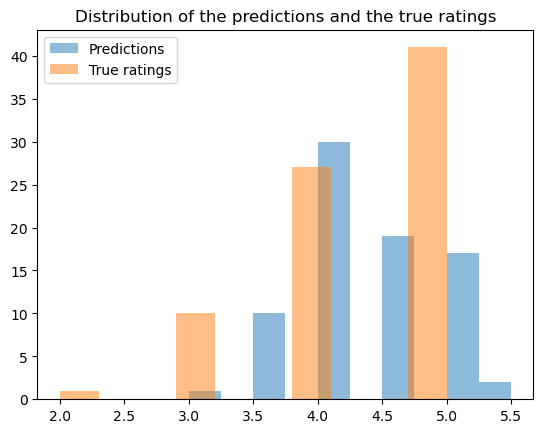

Accuracy : 0.3960060775279999


In [333]:
# Plot the distribution of the predictions and the true ratings
plt.hist(predictions[mask == 1].cpu(), bins=10, alpha=0.5, label='Predictions')
plt.hist(true_ratings[mask == 1].cpu(), bins=10, alpha=0.5, label='True ratings')
plt.legend()
plt.title("Distribution of the predictions and the true ratings")
plt.show()

def compute_accuracy(pred, true, mask) :
    accuracy = torch.sum((pred==true)*mask)/torch.sum(mask)
    return accuracy.item()

accuracy = compute_accuracy(predictions_test_rounded, ratings_test.to(device), mask_test.to(device))
print(f"Accuracy : {accuracy}")